In [ ]:
!pip install torch transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00


In [ ]:
!pip install datasets


In [ ]:
from datasets import load_dataset



In [ ]:
imagenetDataset = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    ignore_verifications=True
)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2491: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

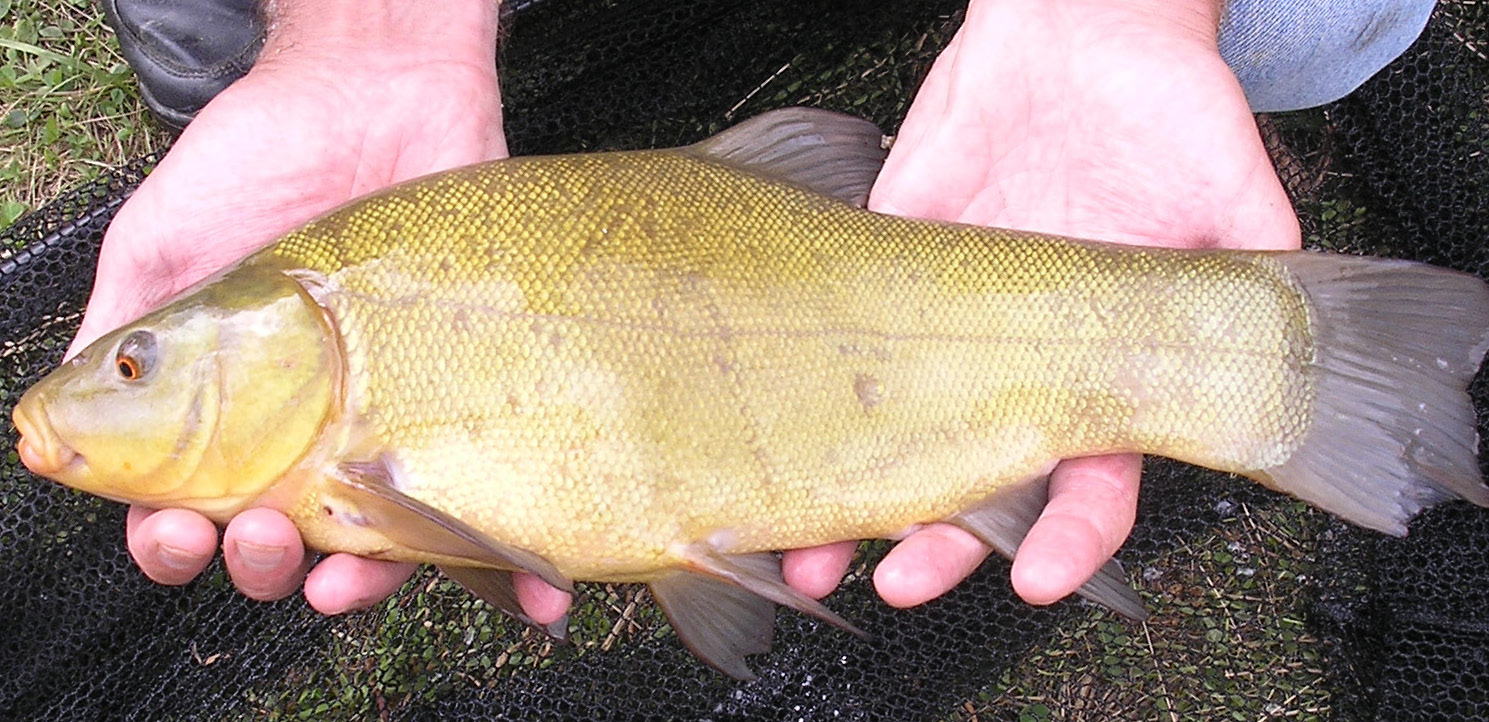

In [ ]:
imagenetDataset[1746]['image']

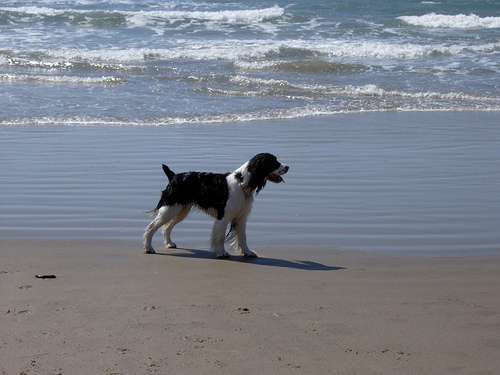

In [ ]:
imagenetDataset[6490]['image']

In [ ]:
from transformers import CLIPTokenizerFast , CLIPProcessor , CLIPModel

In [ ]:
model_name = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_name)
tokenizer = CLIPTokenizerFast.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [ ]:
prompt1 = "dog in the beach"
prompt2= "holding golden fish"
inputs1 = tokenizer(prompt1,return_tensors="pt")
inputs2 = tokenizer(prompt2,return_tensors="pt")

print(inputs1,inputs2)

textEmb1 = model.get_text_features(**inputs1)
textEmb2 = model.get_text_features(**inputs2)
print(textEmb1.shape)

{'input_ids': tensor([[49406,  1929,   530,   518,  2117, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])} {'input_ids': tensor([[49406,  5050,  3878,  2759, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
torch.Size([1, 512])


In [ ]:
image_inputs1 = processor(images = imagenetDataset[6490]['image'],return_tensors="pt")['pixel_values']
image_inputs2 = processor(images = imagenetDataset[1746]['image'],return_tensors="pt")['pixel_values']
print(image_inputs1.shape)

imgEmb1 = model.get_image_features(image_inputs1)
imgEmb2 = model.get_image_features(image_inputs2)
print(imgEmb1.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 512])


In [ ]:
import numpy as np
def getScores(embImg,embTxt):
  embTxt = embTxt / np.linalg.norm(embTxt, axis=0)
  return np.dot(embTxt,embImg.T)


In [ ]:
print(getScores(imgEmb1.squeeze(0).detach().numpy(),textEmb1.squeeze(0).detach().numpy()))
print(getScores(imgEmb1.squeeze(0).detach().numpy(),textEmb2.squeeze(0).detach().numpy()))
print(getScores(imgEmb2.squeeze(0).detach().numpy(),textEmb2.squeeze(0).detach().numpy()))
print(getScores(imgEmb2.squeeze(0).detach().numpy(),textEmb1.squeeze(0).detach().numpy()))


3.2866302
2.047357
2.7922127
1.356575


ZERO SHOT LEARNING

In [ ]:
labels = ['tench',
 'dog',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [ ]:
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a tench',
 'a photo of a dog',
 'a photo of a cassette player',
 'a photo of a chain saw',
 'a photo of a church',
 'a photo of a French horn',
 'a photo of a garbage truck',
 'a photo of a gas pump',
 'a photo of a golf ball',
 'a photo of a parachute']

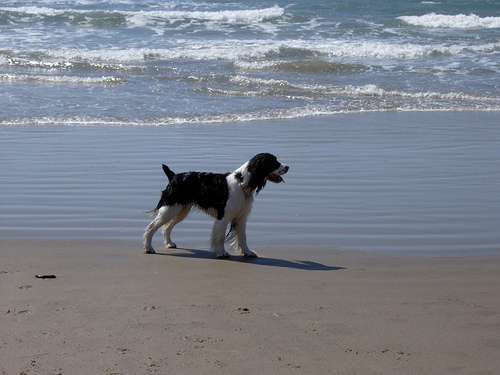

In [ ]:
imagenetDataset[6490]['image']

In [ ]:
image_inputs = processor(images = imagenetDataset[0]['image'],return_tensors="pt")['pixel_values']
imgEmb = model.get_image_features(image_inputs1).squeeze(0).detach().numpy()


In [ ]:
import numpy as np
def getScores(embImg,embTxt):
  #embTxt = embTxt / np.linalg.norm(embTxt, axis=0)
  return np.dot(embTxt,embImg.T)

In [ ]:
for text in clip_labels:

  inputs = tokenizer(text,return_tensors="pt")
  textEmb = model.get_text_features(**inputs).squeeze(0).detach().numpy()
  print(text,getScores(imgEmb,textEmb))




a photo of a tench 15.952801
a photo of a dog 30.6109
a photo of a cassette player 15.101246
a photo of a chain saw 16.733784
a photo of a church 18.62643
a photo of a French horn 15.877838
a photo of a garbage truck 20.437035
a photo of a gas pump 16.257662
a photo of a golf ball 18.147655
a photo of a parachute 17.307932
